In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medianhouseprice/MSPUS.csv


Reference:
Tensorflow tutorials
https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [2]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['axes.grid']=False

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.metrics import mean_absolute_percentage_error

from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [3]:
df=pd.read_csv('/kaggle/input/medianhouseprice/MSPUS.csv')

In [4]:
rows,columns=df.shape[0],df.shape[1]
print(rows,columns)

237 2


In [5]:
#df['DATE']=pd.to_datetime(df['DATE'])
df.set_index('DATE',inplace=True)

In [6]:
df.head()

,MSPUS
DATE,
1963-01-01,17800.0
1963-04-01,18000.0
1963-07-01,17900.0
1963-10-01,18500.0
1964-01-01,18500.0


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MSPUS,237.0,143973.417722,103386.305,17800.0,51600.0,125000.0,224300.0,428700.0


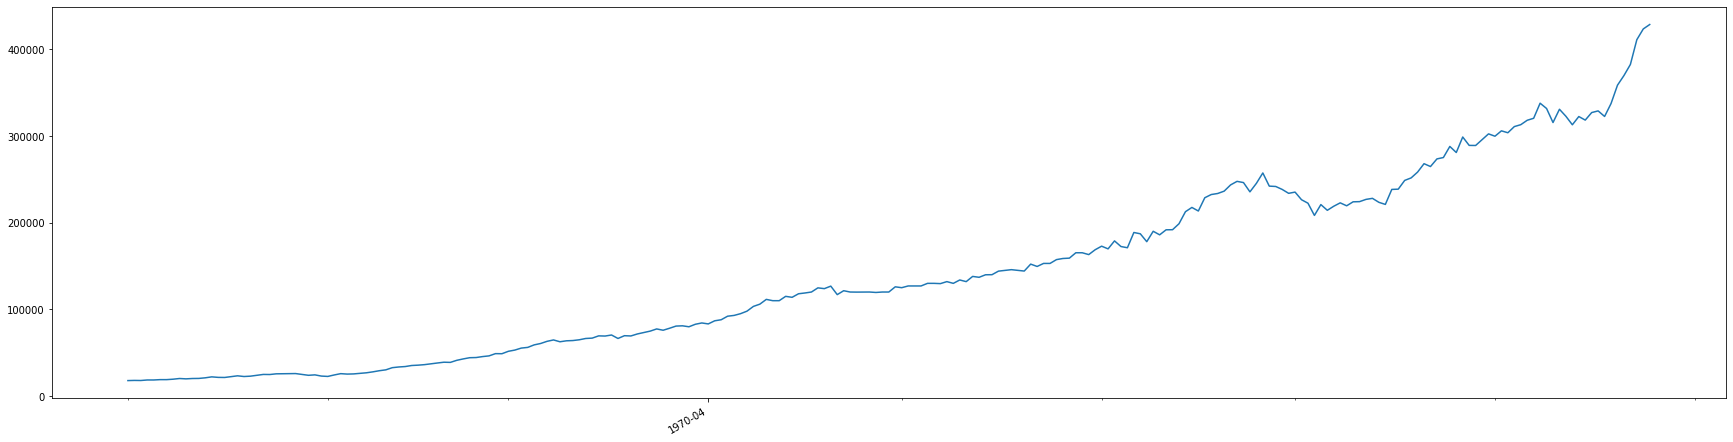

In [8]:
import matplotlib.dates as mdates

fig,ax=plt.subplots(figsize=(30,8))
monthly_locator=mdates.MonthLocator()
year_locator=mdates.MonthLocator(interval=12)
year_month_formatter=mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.plot(df.index,df.MSPUS)
fig.autofmt_xdate()

In [9]:
# Check stationarity of the data
def adf_test(timeseries):
    print("Results of Augmented Dickey-fuller test")
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    print(dfoutput)

In [10]:
df['first_diff']=df['MSPUS'].diff(periods=1)
df.head()

,MSPUS,first_diff
DATE,,
1963-01-01,17800.0,NaN
1963-04-01,18000.0,200.0
1963-07-01,17900.0,-100.0
1963-10-01,18500.0,600.0
1964-01-01,18500.0,0.0


In [11]:
adf_test(df.first_diff.dropna())

Results of Augmented Dickey-fuller test
Test Statistic                  -2.901239
p-value                          0.045204
#lags used                      11.000000
number of observations used    224.000000
critical value (1%)             -3.459885
critical value (5%)             -2.874531
critical value (10%)            -2.573694
dtype: float64


P-Value is at the border . Its less than 0.05 but not much so that we can decide about wether the series is stationary or not.

In [12]:
# Check KPSS test
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [13]:
kpss_test(df.first_diff.dropna())

Results of KPSS Test:
Test Statistic           0.621725
p-value                  0.020661
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Pvalue is not >0.05 so it seems series is not stationary.

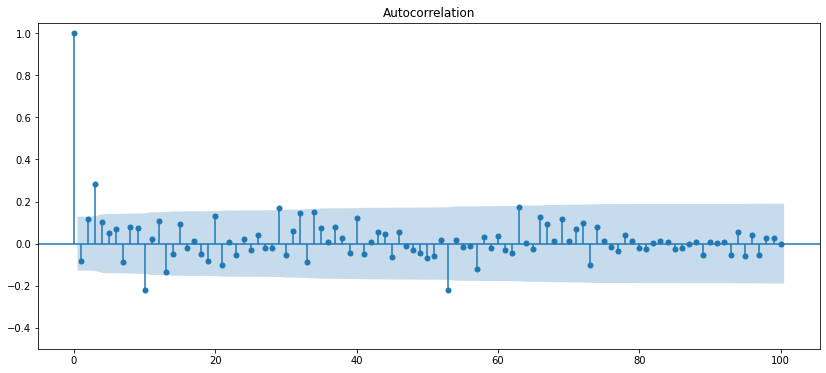

In [14]:
# Check ACF(Autocorrelation)
fig,ax=plt.subplots(figsize=(14,6))
plot_acf(df.first_diff.dropna(),ax=ax,lags=100);
plt.ylim([-0.5,1.05]);

Since series does not pass both tests, we can say that its not stationary.

Split the data in (70%,20%,10%) for the training, validation and test sets. Data is not shuffled before splitting. Because it ensures windows of consecutive samples is still possible and validation/test data looks more realistic.

In [15]:
df.drop(['first_diff'],axis=1,inplace=True)

In [16]:
df.head()

,MSPUS
DATE,
1963-01-01,17800.0
1963-04-01,18000.0
1963-07-01,17900.0
1963-10-01,18500.0
1964-01-01,18500.0


In [17]:
n=len(df)
train_df=df[0:int(n*0.7)]
val_df=df[int(n*0.7):int(n*0.9)]
test_df=df[int(n*0.9):]
num_features=df.shape[1]

###Normalize the data
It is importnat to scale features before training a neural network. Normalization=subtract mean from data and divide by  standard deviation.
Normalization is done only using the training data to preven peeking into validation or test data.

In [18]:
train_mean=train_df.mean()
train_std=train_df.std()

train_df=(train_df-train_mean)/train_std
val_df=(val_df-train_mean)/train_std
test_df=(test_df-train_mean)/train_std

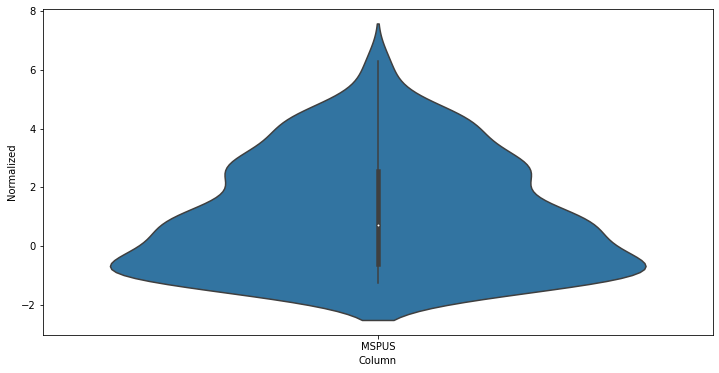

In [19]:
# Check the distribution of price feature. This code is useful even if data has more features
df_std=(df-train_mean)/train_std
df_std=df_std.melt(var_name='Column',value_name='Normalized')
plt.figure(figsize=(12,6))
ax=sns.violinplot(x='Column',y ='Normalized',data=df_std)


Windowing Data
We will use window of consecutive samples from the data to predict multiple time point in future.
Create WindowGenerator class to create windows as required.
This class makes winodws of trainaing, validation and test Dataframes. The data will be converted to tf.data.Dataset of windows.

In [20]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [21]:
#Generate window with width=10 label_width=1 and shift=10
w1=WindowGenerator(input_width=10, label_width=1,shift=10,label_columns=['Price'])
w1

Total window size: 20
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [19]
Label column name(s): ['Price']

In [22]:
# Check another example
w2=WindowGenerator(input_width=5, label_width=1,shift=1,label_columns='House Price')
w2

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): House Price